In [2]:
import sys
sys.path.append("../../BayesFlow")
sys.path.append("../")

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import numpy as np
import pickle

import keras

In [3]:
import bayesflow as bf
from dmc import DMC

network_name = "testrun"

model_specs = {'prior_means': np.array([16., 111., 0.5, 322., 75.]),
               'prior_sds': np.array([10., 47., 0.13, 40., 23.]),
               'tmax': 1200,
               'num_obs': 200,
               'network_name': network_name}

file_path = '../model_specs/model_specs_' + network_name + '.pickle'

with open(file_path, 'wb') as file:
    pickle.dump(model_specs, file)

with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).


## Create Simulator

In [4]:
simulator = DMC(
    prior_means=model_specs['prior_means'], 
    prior_sds=model_specs['prior_sds'],
    tmax=model_specs['tmax'],
    # contamination_probability=.05,
    num_obs=model_specs['num_obs']
)


In [6]:
sims = simulator.sample(10)
for k, v in sims.items():
    print(f"Shape of {k}: {v.shape}")

Shape of A: (10, 1)
Shape of tau: (10, 1)
Shape of mu_c: (10, 1)
Shape of mu_r: (10, 1)
Shape of b: (10, 1)
Shape of rt: (10, 200, 1)
Shape of accuracy: (10, 200, 1)
Shape of conditions: (10, 200, 1)
Shape of num_obs: (10, 1)


## Create Adapter

In [5]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .sqrt("num_obs")
    .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
    .concatenate(["rt", "accuracy", "conditions"], into="summary_variables")
    .standardize(include="inference_variables")
    .rename("num_obs", "inference_conditions")
)

In [8]:
for k, v in adapter(sims).items():
    print(f"Shape of {k}: {v.shape}")

Shape of inference_variables: (10, 5)
Shape of summary_variables: (10, 200, 3)
Shape of inference_conditions: (10, 1)


## Create Networks and Workflow

In [6]:
inference_net = bf.networks.CouplingFlow(coupling_kwargs=dict(subnet_kwargs=dict(dropout=0.011529)), depth=7)

# inference_net = bf.networks.FlowMatching(subnet_kwargs=dict(dropout=0.1))

summary_net = bf.networks.SetTransformer(summary_dim=32, num_seeds=2, dropout=0.011529)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    initial_learning_rate=0.000829376961,
    inference_network=inference_net,
    summary_network=summary_net,
    checkpoint_filepath='../data/training_checkpoints',
    checkpoint_name= network_name,
    inference_variables=["A", "tau", "mu_c", "mu_r", "b"]
)

Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)


## Generate Data and Train Offline

In [10]:
file_path = '../data/data_offline_training/data_offline_training_' + network_name + '.pickle'

train_data = simulator.sample(30000)

with open(file_path, 'wb') as file:
    pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)
    
    

val_file_path = '../data/data_offline_training/data_offline_validation_' + network_name + '.pickle'

val_data = simulator.sample(1000)

with open(val_file_path, 'wb') as file:
    pickle.dump(val_data, file)

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)
    

In [7]:
file_path = '../data/data_offline_training/data_offline_training_' + network_name + '.pickle'

# train_data = simulator.sample(50000)

# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

with open(file_path, 'rb') as file:
    train_data = pickle.load(file)


In [8]:
    
val_file_path = '../data/data_offline_training/data_offline_validation_' + network_name + '.pickle'

with open(val_file_path, 'rb') as file:
    val_data = pickle.load(file)

In [33]:
%%time
history = workflow.fit_offline(train_data, epochs=1, batch_size=128, validation_data=val_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


235/235 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - loss: 4.9212 - loss/inference_loss: 4.9212 - val_loss: 3.6513 - val_loss/inference_loss: 3.6513


INFO:bayesflow:Training is now finished.
            You can find the trained approximator at '../data/training_checkpoints/testrun.testrun.keras'.
            To load it, use approximator = keras.saving.load_model(...).


CPU times: user 28min 39s, sys: 1min 56s, total: 30min 36s
Wall time: 4min 17s


## In Silico Validation
figs = workflow.plot_default_diagnostics(test_data=val_data)

In [36]:
approximator = keras.saving.load_model("../data/training_checkpoints/" + network_name + ".keras")

# figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))


In [37]:
# _ = workflow.adapter(val_data, strict=True, stage="inference")

posterior_samples = approximator.sample(conditions=val_data, num_samples=1000)

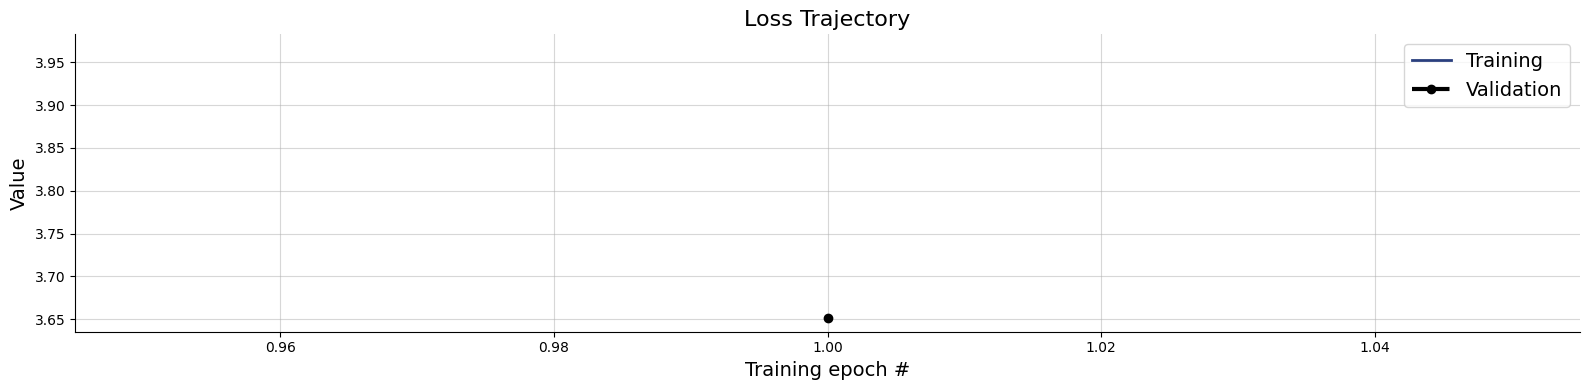

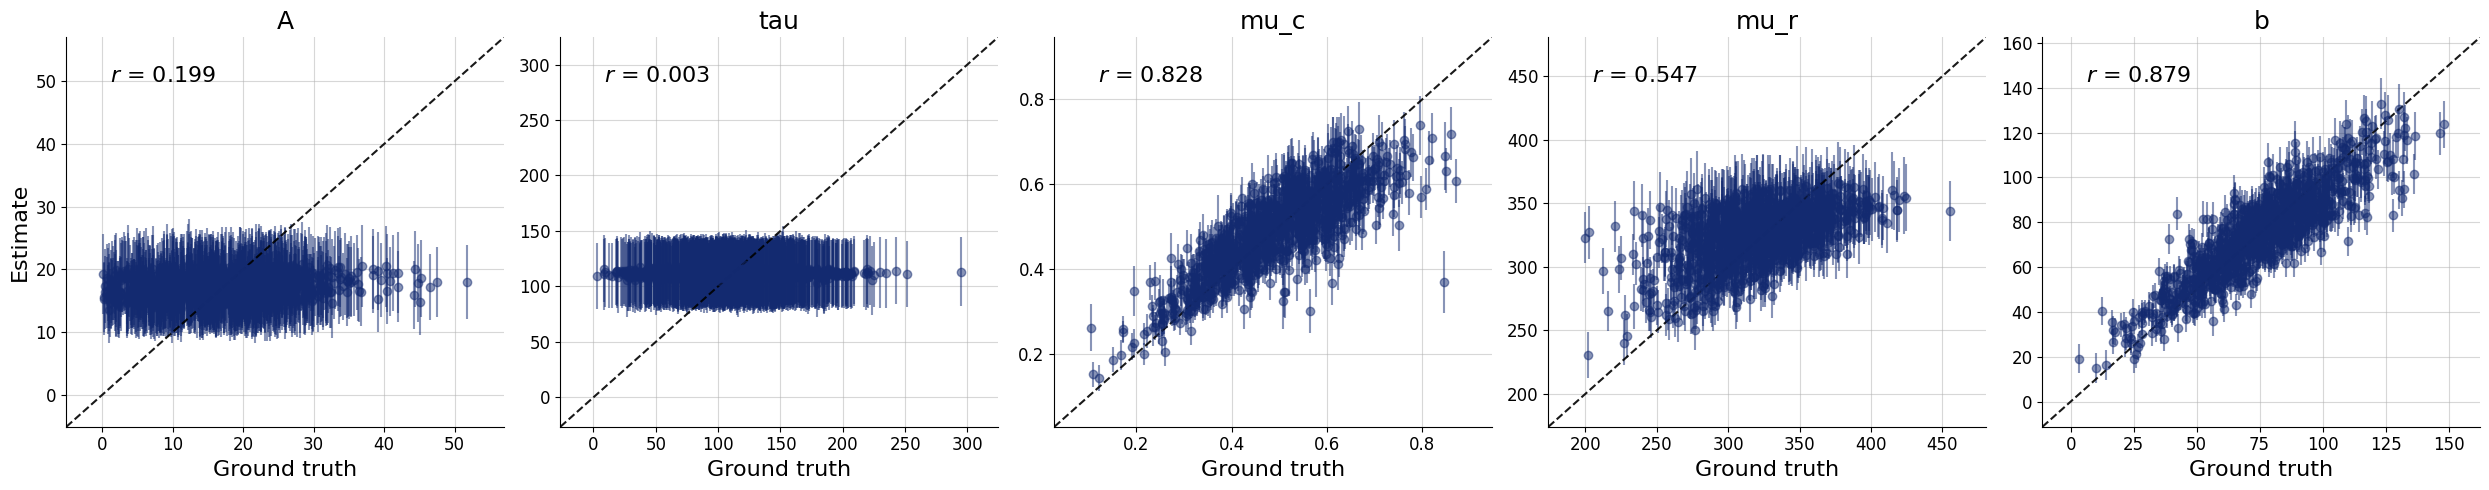

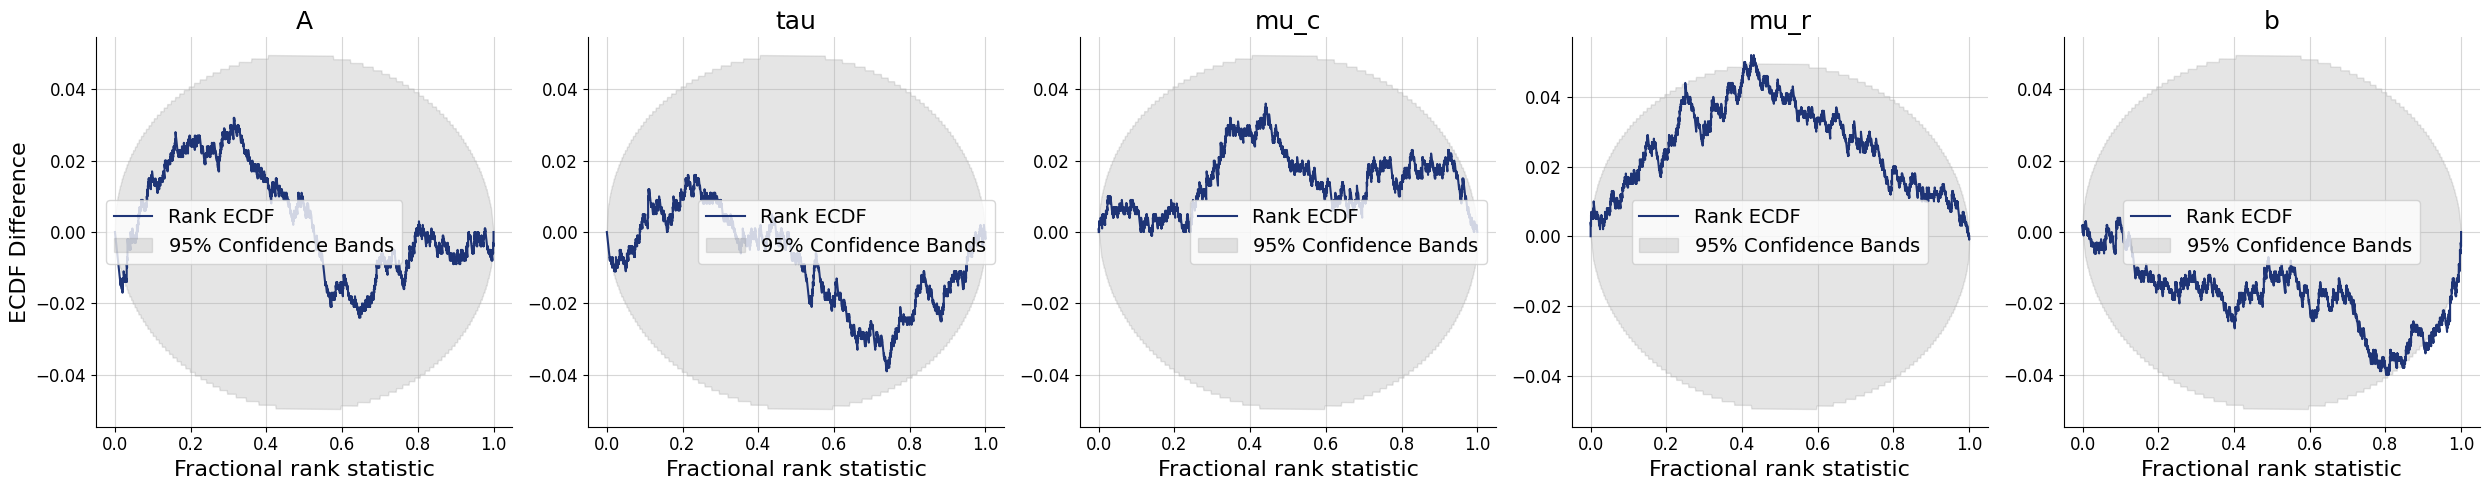

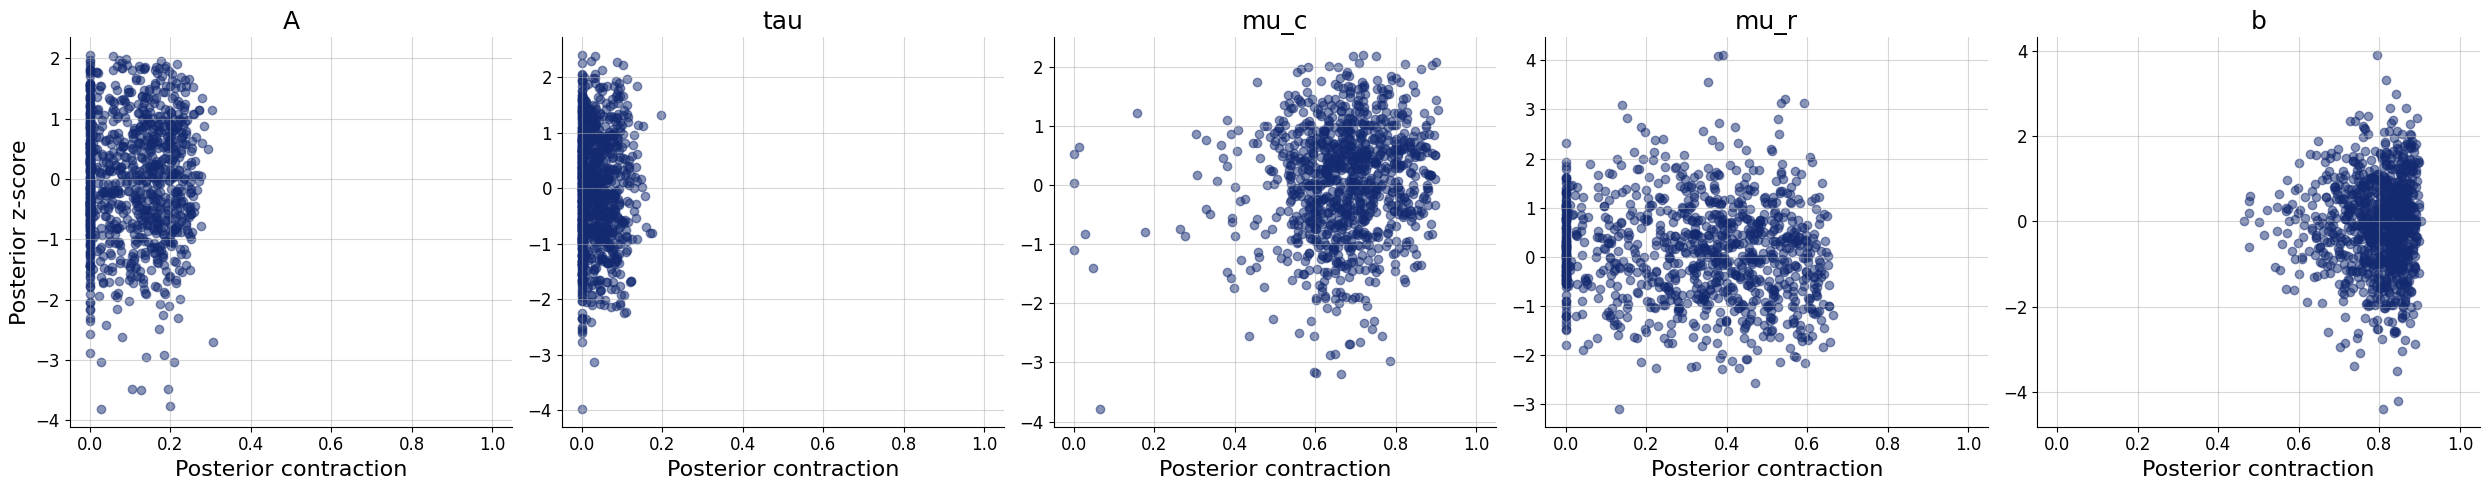

In [38]:
figs = workflow.plot_default_diagnostics(test_data=val_data, calibration_ecdf_kwargs=dict(difference=True))

In [28]:
table = workflow.compute_default_diagnostics(test_data=val_data)
table

TypeError: normal(): argument 'size' failed to unpack the object at pos 3 with error "type must be tuple of ints,but got NoneType"

In [ ]:
# table = workflow.compute_custom_diagnostics(test_data=val_data)

TypeError: BasicWorkflow.compute_custom_diagnostics() missing 1 required positional argument: 'metrics'

## Custom Stuff

In [28]:
samples = approximator.sample(conditions=val_data, num_samples=1000)

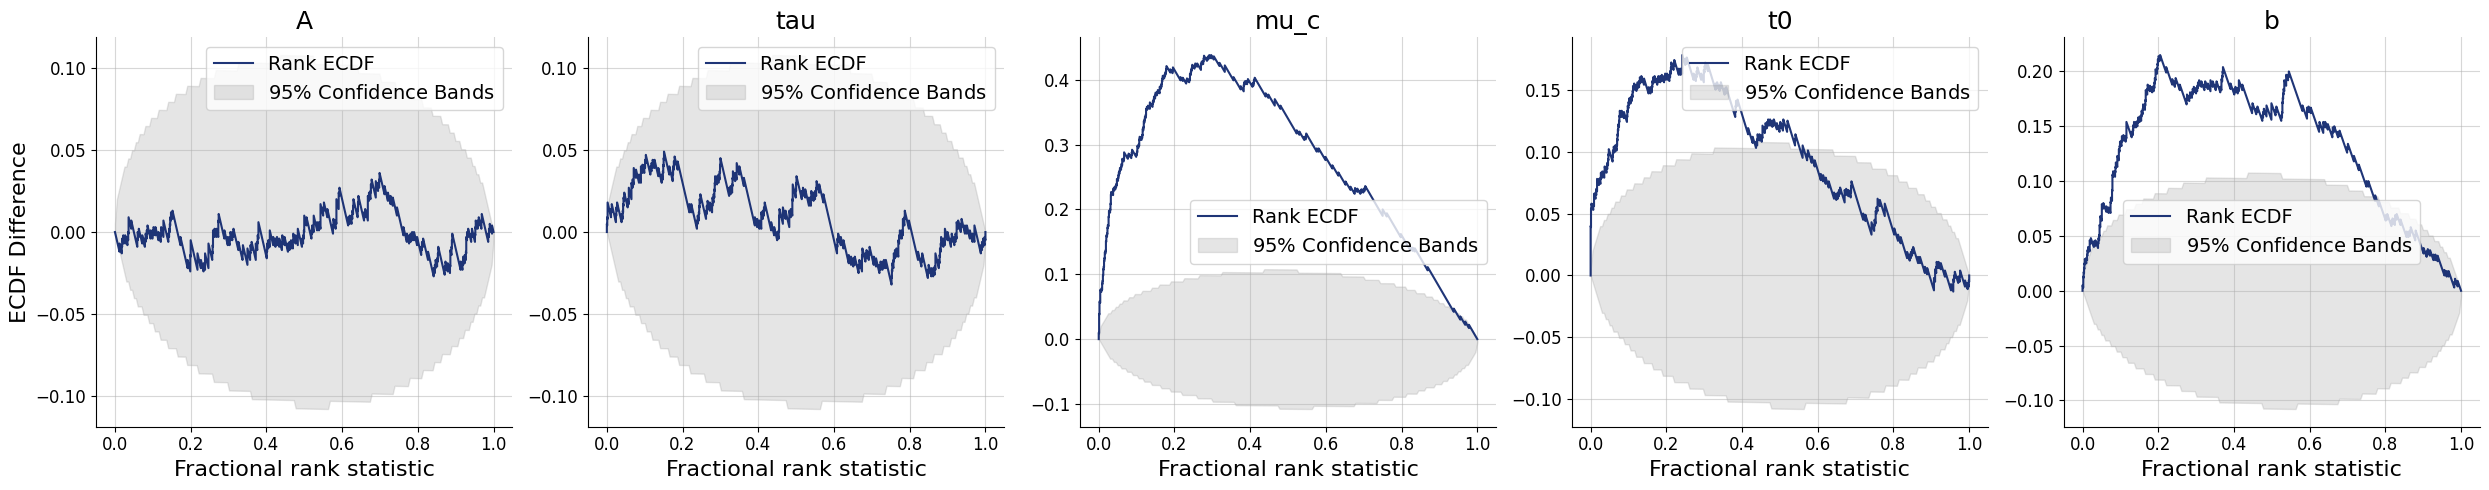

In [29]:
sbc = bf.diagnostics.plots.calibration_ecdf(samples, val_data, variable_keys=["A", "tau", "mu_c", "t0", "b"], difference=True)

## Real Data Inference

In [ ]:
#TODO



## Posterior Predictive Checks

In [ ]:
#TODO